In [111]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2



data=pd.read_csv('train.csv')
data['id'] = data['id'].astype(str)


### Importing video data
processing video that goes in the DashCam
- Event type - Whether the video contains collision/near-collision or normal driving;
- Event time - Time at which a (near-)collision happens (if appliable);
- Alert time – The earliest time in the video when the accident (or near-collision) could be predicted.


In [112]:
import numpy as np

def _pad_or_sample_clip(frames, target_len):
    """Ensure the list of frames has length == target_len by sampling or padding."""
    n = len(frames)
    if n == target_len:
        return frames
    if n < target_len:
        # Pad by repeating the last frame
        last_frame = frames[-1]
        frames.extend([last_frame] * (target_len - n))
        return frames
    else:
        # Sample uniformly to reduce to target_len
        idxs = np.linspace(0, n - 1, num=target_len, dtype=int)
        return [frames[i] for i in idxs]

def get_event_clip(frames, fps, t_alert, t_event, clip_length_sec=8, fixed_frames=16):
    """
    Extract a clip from the list of frames based on event timing,
    then downsample (if needed) and finally adjust the clip to a fixed number of frames.
    """
    total_frames = len(frames)
    if t_event is None:
        end_idx = total_frames - 1
    else:
        end_idx = min(total_frames - 1, int(t_event * fps))
    start_idx = max(0, end_idx - int(clip_length_sec * fps))
    clip = frames[start_idx: end_idx + 1]
    
    return np.array(clip)


### data augmentation 
- randomized cropping
- random horizontal flipping
- random b/con
- Normalization

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define an augmentation pipeline for a single frame
aug = A.Compose([
    #A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
    A.Resize(242, 430),#430
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    # ... add more as needed
    A.Normalize(mean=(0.45,0.45,0.45), std=(0.225,0.225,0.225)),
    ToTensorV2()
])
def augment_clip(frames):
    """
    Applies the same augmentation to each frame in a list and
    returns a torch tensor of shape (T, C, H, W).
    """
    augmented = []
    for frame in frames:
        # albumentations expects images in HxWxC order (uint8)
        image_aug = aug(image=frame)['image']
        augmented.append(image_aug)
    return torch.stack(augmented)  # shape: (T, C, H, W)

In [114]:
# Set the output video parameters
def save_video(clip):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 24  # Adjust as needed
    frame_size = (355, 200)  # Should match the resized frame dimensions

    # Create the VideoWriter object
    out = cv2.VideoWriter('train/000000000000.mp4', fourcc, fps, frame_size)

    # Write each frame to the output video file
    for frame in clip:
        out.write(frame)

    out.release()

### plotting distribution
- length of video clips and normalizing entropy

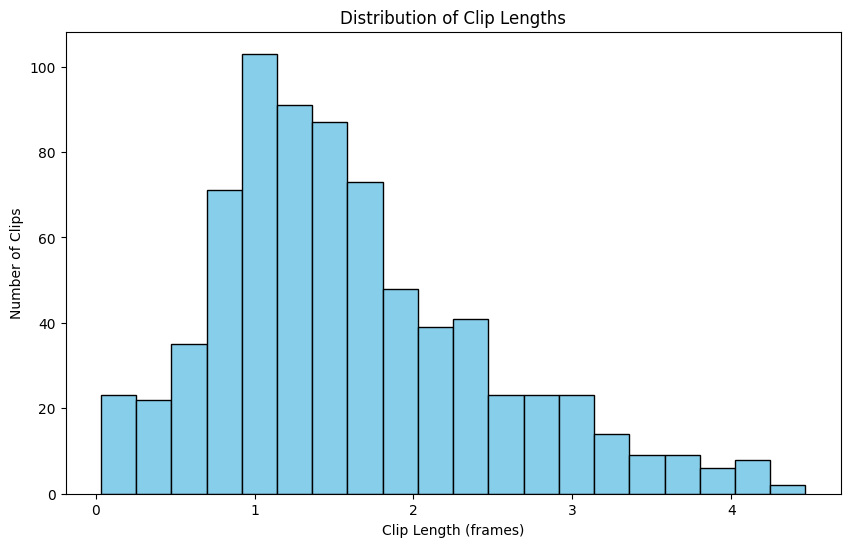

Mean clip length: 1.6003573333333334
Sample random clip length from distribution: 1.6690000000000005


In [115]:



clip_lengths = []
# Loop over each video in the DataFrame
for index, video in data.iterrows():
    if not math.isnan(video['time_of_event']):
        t_event = video['time_of_event']
        t_alert = video['time_of_alert']
        # Calculate clip length in seconds from t_event and t_alert
        clip_length_sec = t_event - t_alert

        clip_lengths.append(clip_length_sec)
        

# Plot the distribution of clip lengths
plt.figure(figsize=(10, 6))
plt.hist(clip_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Clip Lengths")
plt.xlabel("Clip Length (frames)")
plt.ylabel("Number of Clips")
plt.show()
print("Mean clip length:", np.mean(clip_lengths))


# Define a function to return a random clip length from the observed distribution
def get_random_length():
    return random.choice(clip_lengths)

print("Sample random clip length from distribution:", get_random_length())


In [116]:
class CollisionDataset(Dataset):
    def __init__(self, df, video_dir, augment=False):
        """
        Initialize the CollisionDataset.
        
        For collision videos (with valid time_of_alert and time_of_event), this class:
          - Extracts a singular clip spanning from time_of_alert to time_of_event.
          - Generates a target label as a scalar 1 (collision).
        
        For non-collision videos, a single random clip is extracted (ensuring at least self.clip_length frames)
        and its label is 0 (no collision).
        
        Parameters:
          df: Pandas DataFrame with video metadata. Must contain:
              - 'id': video identifier (will be zero-filled to length 5 and appended with '.mp4')
              - 'time_of_alert' and 'time_of_event' for collision videos.
          video_dir: Directory where video files are stored.
          augment: Whether to apply augmentation on clips.
        """
        self.video_dir = video_dir
        self.augment = augment
        self.clip_length = 16  # fixed number of frames per clip
        self.segments = []     # list of tuples: (video_path, start_frame, end_frame, label)
        
        for _, row in df.iterrows():
            # Build video filename using the 'id' column
            video_filename = str(row['id']).zfill(5) + ".mp4"
            video_path = (video_filename if os.path.isabs(video_filename)
                          or video_dir == "" else os.path.join(video_dir, video_filename))
            
            # Open video to get total frame count and FPS
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Skipping {video_path}: cannot be opened")
                continue
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            if fps is None or fps <= 0:
                fps = 30.0  # fallback FPS
            cap.release()
            
            # Determine if this is a collision video (requires time_of_alert and time_of_event)
            if ('time_of_alert' in row and row['time_of_alert'] not in [None, "", np.nan] and pd.notna(row['time_of_alert'])) and \
               ('time_of_event' in row and row['time_of_event'] not in [None, "", np.nan] and pd.notna(row['time_of_event'])):
                t_alert = float(row['time_of_alert'])
                t_event = float(row['time_of_event'])
                start_frame = int(t_alert * fps)
                event_frame = int(t_event * fps)
                if event_frame >= total_frames:
                    event_frame = total_frames - 1
                end_frame = event_frame + 1  # exclusive
                # Instead of a temporal vector, set the label to 1 (collision)
                label = np.array(1, dtype=np.float32)
                self.segments.append((video_path, start_frame, end_frame, label))
            else:
                # Non-collision video: extract 4 random clips with label 0
                if total_frames < self.clip_length:
                    print(f"Skipping {video_path}: too short")
                    continue
                prev_end_frame = 0
                for _ in range(3):  # select 3 random clips (or adjust the number as needed)
                    start_frame = prev_end_frame
                    if start_frame >= total_frames:
                        break
                    # Use your get_random_length() function to select a clip length
                    clip_len = get_random_length()
                    end_frame = start_frame + clip_len
                    label = np.array(0, dtype=np.float32)
                    self.segments.append((video_path, start_frame, end_frame, label))
                    prev_end_frame = end_frame + 2
                            
    def __len__(self):
        return len(self.segments)
    
    def __getitem__(self, idx):
        video_path, start_frame, end_frame, label = self.segments[idx]
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError(f"Cannot open video: {video_path}")
            
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        frames = []
        frame_idx = start_frame

        while frame_idx < end_frame:
            ret, frame = cap.read()
            if not ret:
                break
            # Resize frame; note: cv2.resize uses (width, height)
            frames.append(frame)
            frame_idx += 1
            
        cap.release()

        if len(frames) == 0:
            raise RuntimeError(f"No frames read for segment {idx} from video {video_path}")

        # Ensure the clip has self.clip_length frames
        frames = _pad_or_sample_clip(frames, self.clip_length)

        if self.augment:
            # Augment the clip; resulting tensor will be (T, C, H, W)
            clip_tensor = augment_clip(frames)
            clip_tensor = clip_tensor.permute(1, 0, 2, 3)  # rearrange to (C, T, H, W)
        else:
            # Convert frames to a tensor; from (T, H, W, C) to (C, T, H, W)
            clip_array = np.stack(frames, axis=0).astype(np.float32) / 255.0
            clip_array = np.transpose(clip_array, (3, 0, 1, 2))
            clip_tensor = torch.from_numpy(clip_array)

        # Convert label to a torch tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return clip_tensor, label_tensor


### finally at the training loop
- Resnet approach

In [117]:
import os
import cv2
import time
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
# make sure you have the appropriate collision dataset defined as CollisionDataset
print(torch.hub.list('facebookresearch/pytorchvideo'))

# --- Prepare your dataset and dataloader ---
video_dir = "train"  # directory where your videos are stored
dataset = CollisionDataset(df=data, video_dir=video_dir, augment=True)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
)

# --- Define the model using MViTv2 ---
# Load a MViTv2 model from PyTorchVideo. Here we load the "small" variant.
model = torch.hub.load('facebookresearch/pytorchvideo', 'mvit_base_32x3', pretrained=True)

# Replace the classification head to output a single logit for binary classification.
# The MViTv2 model typically has a head with a projection, so we reassign that.
model.head.proj = nn.Linear(model.head.proj.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- Define loss and optimizer ---
# Here we use BCEWithLogitsLoss; adjust pos_weight if necessary.
pos_weight = torch.tensor(0.5).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- Training loop with progress printing ---
num_epochs = 7
model.train()

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time of the epoch
    epoch_loss = 0.0
    total_batches = len(dataloader)
    
    for batch_idx, (clips, labels) in enumerate(dataloader, start=1):
        # Move data to device
        clips = clips.float().to(device)
        # Ensure labels have shape (B, 1) to match outputs
        labels = labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(clips)  # Expected output shape: (B, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * clips.size(0)
        
        # Progress printing
        progress = 100 * batch_idx / total_batches
        elapsed = time.time() - epoch_start_time
        avg_batch_time = elapsed / batch_idx
        estimated_remaining = avg_batch_time * (total_batches - batch_idx)
        
        print(
            f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx}/{total_batches} "
            f"({progress:.1f}% done) - Batch Loss: {loss.item():.4f} - "
            f"Est. Time Left: {estimated_remaining:.2f}s",
            end="\r"
        )
    
    epoch_loss /= len(dataset)
    epoch_duration = time.time() - epoch_start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} finished, Average Loss: {epoch_loss:.4f}, Epoch Time: {epoch_duration:.2f}s\n")

# Save the trained model
torch.save(model, "collision_model_MViTv2.pth")


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


['c2d_r50', 'csn_r101', 'efficient_x3d_s', 'efficient_x3d_xs', 'i3d_r50', 'mvit_base_16', 'mvit_base_16x4', 'mvit_base_32x3', 'r2plus1d_r50', 'slow_r50', 'slow_r50_detection', 'slowfast_16x8_r101_50_50', 'slowfast_r101', 'slowfast_r50', 'slowfast_r50_detection', 'x3d_l', 'x3d_m', 'x3d_s', 'x3d_xs']


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


KeyboardInterrupt: 

In [ ]:
# video_dir = "train"  # directory where your videos are stored
# dataset = CollisionDataset(dataframe=data, video_dir="train", fps=30, transform=True)
# print('Number of samples:', dataset.__len__())

# dataloader = DataLoader(
#     dataset,
#     batch_size=8,
#     shuffle=True,
#     num_workers=8  # You can increase this to 2 or 4 if not on Windows
# )

# # --- Define the model ---
# model = models.video.r3d_18(weights=models.video.R3D_18_Weights.DEFAULT)
# model.fc = nn.Linear(model.fc.in_features, 1)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # --- Define loss and optimizer ---
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # --- Training loop with progress printing ---
# num_epochs = 11

# model.train()
# import time

# for epoch in range(num_epochs):
#     epoch_start_time = time.time()  # Start time of the epoch
#     epoch_loss = 0.0
#     total_batches = len(dataloader)
    
#     for batch_idx, (clips, labels) in enumerate(dataloader, start=1):
#         clips = clips.float().to(device)
#         labels = labels.unsqueeze(1).to(device)  # shape: (B, 1)
        
#         optimizer.zero_grad()
#         outputs = model(clips)  # outputs shape: (B, 1)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item() * clips.size(0)
        
#         # Calculate progress and estimated time remaining
#         progress = 100 * batch_idx / total_batches
#         elapsed = time.time() - epoch_start_time
#         avg_batch_time = elapsed / batch_idx
#         estimated_remaining = avg_batch_time * (total_batches - batch_idx)
        
#         print(
#             f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx}/{total_batches} "
#             f"({progress:.1f}% done) - Batch Loss: {loss.item():.4f} - "
#             f"Est. Time Left: {estimated_remaining:.2f}s",
#             end="\r"
#         )
    
#     epoch_loss /= len(dataset)
#     epoch_duration = time.time() - epoch_start_time
#     print(f"\nEpoch {epoch+1}/{num_epochs} finished, Average Loss: {epoch_loss:.4f}, Epoch Time: {epoch_duration:.2f}s\n")

# torch.save(model, "collision_model.pth")

#662 min 12 epoch 375 batch 20 min 375


In [ ]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
import pytorchvideo
import torch.nn as nn

# --- Define a test transform (deterministic normalization and tensor conversion) ---
test_aug = A.Compose([
    #A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
    A.Resize(242, 430),#430
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    # ... add more as needed
    A.Normalize(mean=(0.45,0.45,0.45), std=(0.225,0.225,0.225)),
    ToTensorV2()
])

def test_transform_clip(frames):
    """
    Applies a deterministic transform (normalization and conversion to tensor)
    to a list of frames.
    Returns a tensor of shape (T, C, H, W).
    """
    transformed_frames = []
    for frame in frames:
        # Albumentations expects HxWxC image
        transformed = test_aug(image=frame)['image']
        transformed_frames.append(transformed)
    return torch.stack(transformed_frames)

def sliding_window_clips(frames, window_size, stride):
    """
    Splits the full list of frames into clips using a sliding window.
    Returns a list of clips (each a list of frames) and their corresponding start indices.
    """
    clips = []
    indices = []
    for start in range(0, len(frames) - window_size + 1, stride):
        clip = frames[start: start + window_size]
        clips.append(clip)
        indices.append(start)
    return clips, indices

# --- Load the trained model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("collision_model_SlowR50.pth", weights_only=False)

model.eval()


# --- Parameters ---
test_folder = "test"    # folder with test videos (assumed to be .mp4)
fps = 30                # frames per second (adjust if needed)
window_size = 16        # fixed number of frames per clip
stride = 8          # sliding window stride
threshold = 0.9      # threshold to determine collision (target = 1)

def save_resized_video(frames, output_path, fps=30, frame_size=(355, 200)):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
    for frame in frames:
        out.write(frame)
    out.release()



# --- Process each test video ---
for video_file in os.listdir(test_folder):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(test_folder, video_file)
        print(f"\nProcessing video: {video_file}")
        
        # Read the video frames using OpenCV
        vidcap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            success, frame = vidcap.read()
            if not success:
                break
            # Resize frames to the expected size (should match training resize)
            frame = cv2.resize(frame, (355, 200))
            frames.append(frame)
        vidcap.release()
        resized_output_path = os.path.join("resized_videos", video_file)
        os.makedirs("resized_videos", exist_ok=True)
        save_resized_video(frames, resized_output_path, fps=fps, frame_size=(355, 200))
        
        if len(frames) < window_size:
            print(f"Video {video_file} too short (only {len(frames)} frames). Skipping.")
            continue
        
        # Extract sliding window clips and record the starting indices
        clips, indices = sliding_window_clips(frames, window_size, stride)
        
        best_prob = 0.0
        best_index = None
        # Evaluate each clip
        probabilities = []
        for clip, idx in zip(clips, indices):
            clip_tensor = test_transform_clip(clip)
            clip_tensor = clip_tensor.permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
            with torch.no_grad():
                output = model(clip_tensor)
                probAvg = torch.sigmoid(output).max().item()
                probabilities.append(probAvg)
                if probAvg > best_prob:
                    best_prob = probAvg
                    best_index = idx
        # Aggregate predictions (e.g., average)

        avg_prob = np.mean(probabilities)
        predicted_target = 1 if avg_prob >= threshold else 0
        # Determine predicted target using a threshold
        #predicted_target = 1 if best_prob >= threshold else 0
        # Convert best_index to time in milliseconds: (frame index / fps) * 1000
        if best_index is not None:
            predicted_time_ms = (best_index / fps) * 1000
        else:
            predicted_time_ms = None
        print(f"Average Probability: {avg_prob:.2f} max: {best_prob:.2f}")
        if avg_prob>0.8:
            print(f"Predicted Target: {predicted_target} (Probability: {best_prob:.2f})")
            if predicted_time_ms is not None:
                print(f"Predicted Collision Time: {predicted_time_ms:.0f} ms")
        else:
            print("No valid clip found for prediction.")


- run the cell to make test resized videos

In [ ]:
test_folder = "test"    # folder with test videos (assumed to be .mp4)
fps = 30                # frames per second (adjust if needed)
window_size = 16        # fixed number of frames per clip
stride = 4              # sliding window stride
threshold = 0.6         # threshold to determine collision (target = 1)


for video_file in os.listdir(test_folder):
    if video_file.endswith(".mp4"):
        video_path = os.path.join(test_folder, video_file)
        #print(f"\nProcessing video: {video_file}")
        
        # Read the video frames using OpenCV
        vidcap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            success, frame = vidcap.read()
            if not success:
                break
            # Resize frames to the expected size (should match training resize)
            frame = cv2.resize(frame, (355, 200))
            frames.append(frame)
        vidcap.release()
        resized_output_path = os.path.join("resized_videos", video_file)
        os.makedirs("resized_videos", exist_ok=True)
        save_resized_video(frames, resized_output_path, fps=fps, frame_size=(355, 200))